# Optimized Selection

Taking the original, and trying to make it more compact, and do both muons and electrons - because that is what we will need for the actual test.

In [1]:
from func_adl_servicex import ServiceXSourceCMSRun1AOD
import awkward as ak
from hist import Hist
import mplhep as mpl

Setup the original dataset we are going to source from, and split it into the bits that we need.

In [11]:
data_source = (
    ServiceXSourceCMSRun1AOD("cernopendata://1507")
    .Select(lambda e: {
        "m": e.Muons("muons"),
        "e": e.GsfElectrons("gsfElectrons"), 
        "p": e.Vertex("offlinePrimaryVertices")[0].position()
    })
)

Now, lets grab the good muons from this list. The selection is obviously large and complex...

In [12]:
data_muons = (
     data_source
     .Select(lambda i: {
          "m": i.m
               .Where(lambda m: m.isPFMuon()
                         and m.isPFIsolationValid()
                         and isNonnull(m.globalTrack())
                         and abs(sqrt((m.globalTrack().dxy(i.p) * m.globalTrack().dxy(i.p))
                                   + (m.globalTrack().dz(i.p) * m.globalTrack().dz(i.p)))
                              / sqrt((m.globalTrack().d0Error() * m.globalTrack().d0Error())
                                        + (m.globalTrack().dzError() * m.globalTrack().dzError()))) < 4.0
                         and abs((m.globalTrack()).dxy(i.p)) < 0.5
                         and abs((m.globalTrack()).dz(i.p)) < 1.
                         and ((m.pfIsolationR04()).sumChargedHadronPt
                              + (m.pfIsolationR04()).sumNeutralHadronEt
                              + (m.pfIsolationR04()).sumPhotonEt) / m.pt() < 0.4
                         and m.pt() > 5.
                         and abs(m.eta()) < 2.4
               ),
          "e": i.e
               .Where(lambda e: e.passingPflowPreselection()
                         and e.pt() > 7.
                         and abs(e.superCluster().eta()) < 2.5
                         and e.gsfTrack().trackerExpectedHitsInner().numberOfHits() <= 1
                         and abs(sqrt((e.gsfTrack().dxy(i.p) * e.gsfTrack().dxy(i.p))
                                   + (e.gsfTrack().dz(i.p) * e.gsfTrack().dz(i.p)))
                              / sqrt((e.gsfTrack().d0Error() * e.gsfTrack().d0Error())
                                        + (e.gsfTrack().dzError() * e.gsfTrack().dzError()))) < 4.
                         and abs(e.gsfTrack().dxy(i.p)) < 0.5 and abs(e.gsfTrack().dz(i.p)) < 1.
                         and (e.isEB() or e.isEE())
                         and (e.pfIsolationVariables().chargedHadronIso
                              + e.pfIsolationVariables().neutralHadronIso
                              + e.pfIsolationVariables().photonIso) / e.pt() < 0.4
                         )
     })
)

Now we can pull out the columns of data we want to feed up!

In [13]:
data = (
    data_muons
    .Select(lambda i: (
        i.m.Select(lambda m: m.p()),
        i.m.Select(lambda m: m.pt()),
        i.m.Select(lambda m: m.px()),
        i.m.Select(lambda m: m.py()),
        i.m.Select(lambda m: m.pz()),
        i.m.Select(lambda m: m.charge()),
        i.e.Select(lambda m: m.p()),
        i.e.Select(lambda m: m.pt()),
        i.e.Select(lambda m: m.px()),
        i.e.Select(lambda m: m.py()),
        i.e.Select(lambda m: m.pz()),
        i.e.Select(lambda m: m.charge()),
    ))
    .AsAwkwardArray([
        'mu_p', 'mu_pt', 'mu_px', 'mu_py', 'mu_pz', 'mu_charge',
        'el_p', 'el_pt', 'el_px', 'el_py', 'el_pz', 'el_charge',
    ])
    .value()
)

cernopendata://1507:   0%|          | 0/9000000000.0 [00:00]
cernopendata://1507:   0%|          | 0/9000000000.0 [00:00]
cernopendata://1507:  95%|█████████▌| 21/22 [06:57]
                                                   
        Downloaded: 100%|██████████| 22/22 [07:03]
                                                  

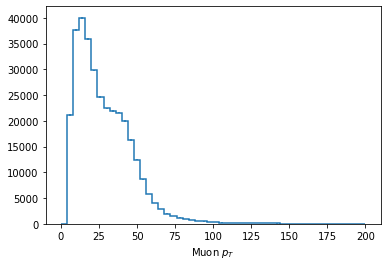

In [14]:
h = (Hist.new
     .Reg(50, 0, 200, name='mu_pt', label='Muon $p_T$')
     .Int64()
     )
h.fill(ak.flatten(data['mu_pt']))
_ = h.plot()

In [16]:
print(data['mu_p'])

[[], [18.9, 24.2], [], [49.5, 40.9], ... [96.6, 189, 22.6], [60.9, 47.5, 25, 23.2]]


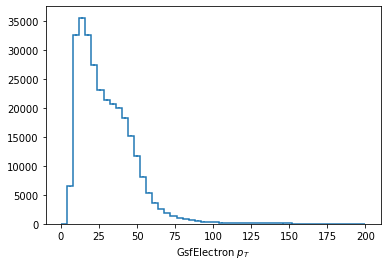

In [18]:
h = (Hist.new
     .Reg(50, 0, 200, name='el_pt', label='GsfElectron $p_T$')
     .Int64()
     )
h.fill(ak.flatten(data['el_pt']))
_ = h.plot()